# Pose Detection from Youtube Instructional video with VIBE

This notebook uses the open-source project [/mkocabas/VIBE](https://github.com/mkocabas/VIBE) to detect person shape and pose from instructional videos from Youtube.

It is inspired from [/tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb) and makes use of  [youtube-dl program](https://github.com/ytdl-org/youtube-dl) to load and extract frames from Youtube videos.


## Install Vibe

In [1]:
# Clone the repo
!git clone https://github.com/mkocabas/VIBE.git

%cd VIBE/

# Install the other requirements
!pip install torch==1.4.0 numpy==1.17.5
!pip install git+https://github.com/giacaglia/pytube.git --upgrade
!pip install -r requirements.txt

# Download pretrained weights and SMPL data
!source scripts/prepare_data.sh

Cloning into 'VIBE'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 375 (delta 7), reused 11 (delta 1), pack-reused 349
Receiving objects: 100% (375/375), 15.09 MiB | 50.02 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/VIBE
     |███████████████████▊            | 464.1MB 1.3MB/s eta 0:03:44ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 463, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.

Downloading...
From: https://drive.google.com/uc?id=1untXhYOLQtpNEy4GTY_0fL_H-k6cTf_r
To: /content/VIBE/data/vibe_data.zip
561MB [00:03, 146MB/s]
Archive:  vibe_data.zip
   creating: vibe_data/
  inflating: vibe_data/smpl_mean_params.npz  
  inflating: vibe_data/vibe_model_w_3dpw.pth.tar  
  inflating: vibe_data/gmm_08.pkl    
  inflating: vibe_data/J_regressor_h36m.npy  
  inflating: vibe_data/vibe_model_wo_3dpw.pth.tar  
  inflating: vibe_data/SMPL_NEUTRAL.pkl  
  inflating: vibe_data/J_regressor_extra.npy  
  inflating: vibe_data/spin_model_checkpoint.pth.tar  
  inflating: vibe_data/sample_video.mp4  
  inflating: vibe_data/yolov3.weights  


# Load Video

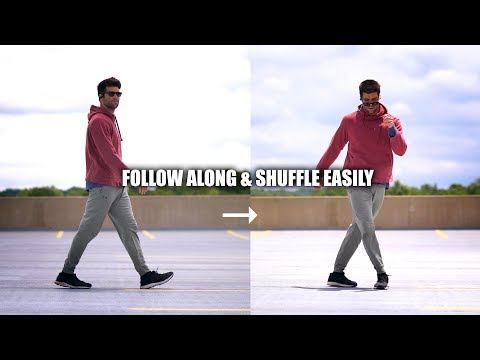

In [2]:
from IPython.display import YouTubeVideo
YOUTUBE_ID = 'Ae3AkGYpWsM'  # 00:17 
YouTubeVideo(YOUTUBE_ID)

In [3]:
# install python dependencies
!pip install -q youtube-dl

!rm -rf youtube.mp4

# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -ss 00:00:36 -t 7 video.mp4

     |████████████████████████████████| 1.9MB 12.0MB/s 
[youtube] Ae3AkGYpWsM: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 57.44MiB in 00:01
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --

# Apply VIBE

To apply VIBE, we run the [VIBE/demo.py](https://github.com/mkocabas/VIBE/blob/master/demo.py) with the default **bbox** tracking method and **Yolo** detector as it gives a good tradeoff between speed and accuracy. 

Please refer to [VIBE/demo.md](https://github.com/mkocabas/VIBE/blob/master/doc/demo.md) for further details about the demo.

In [4]:
%cd /content/VIBE

!python demo.py --vid_file video.mp4 --output_folder ../

/content/VIBE
Running "ffmpeg -i video.mp4 -f image2 -v error /tmp/video_mp4/%06d.png"
Images saved to "/tmp/video_mp4"
Input video number of frames 420
--2021-01-12 00:27:34--  https://raw.githubusercontent.com/mkocabas/yolov3-pytorch/master/yolov3/config/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8338 (8.1K) [text/plain]
Saving to: ‘/root/.torch/config/yolov3.cfg’

yolov3.cfg          100%[===================>]   8.14K  --.-KB/s    in 0s      

2021-01-12 00:27:34 (105 MB/s) - ‘/root/.torch/config/yolov3.cfg’ saved [8338/8338]

Running Multi-Person-Tracker
100% 35/35 [00:28<00:00,  1.26it/s]
Finished. Detection + Tracking FPS 14.71
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resn

# Show results

In [5]:
# this function is borrowed from https://github.com/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

In [6]:
show_local_mp4_video('/content/video/video_vibe_result.mp4', width=960, height=720)

## VIBE Output format

In [7]:
import joblib
output = joblib.load('/content/video/vibe_output.pkl')
print(output.keys()) 

dict_keys([1])


In [8]:
for k,v in output[1].items(): 
  if (k!="joints2d"):
    print(k, v.shape) 

pred_cam (420, 3)
orig_cam (420, 4)
verts (420, 6890, 3)
pose (420, 72)
betas (420, 10)
joints3d (420, 49, 3)
bboxes (420, 4)
frame_ids (420,)


VIBE outputs  a dictionary associating to each tracked person id a vector of the pose and shape predictions along the frames in SMPL format:



```
pred_cam (n_frames, 3)      # weak perspective camera parameters in cropped image space (s,tx,ty)
orig_cam (n_frames, 4)      # weak perspective camera parameters in original image space (sx,sy,tx,ty)
verts (n_frames, 6890, 3)   # SMPL mesh vertices
pose (n_frames, 72)         # SMPL pose parameters
betas (n_frames, 10)        # SMPL body shape parameters
joints3d (n_frames, 49, 3)  # SMPL 3D joints
joints2d (n_frames, 21, 3)  # 2D keypoint detections by STAF if pose tracking enabled otherwise None
bboxes (n_frames, 4)        # bbox detections (cx,cy,w,h)
frame_ids (n_frames,)       # frame ids in which subject with tracking id #1 appears
```

